<a href="https://colab.research.google.com/github/appletiger0704/Titanic/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import pandas as pd
import numpy as np
from google.colab import data_table

# grapg
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [82]:
url = "https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv"
raw = pd.read_csv(url)
data_table.DataTable(raw, include_index=True, num_rows_per_page=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


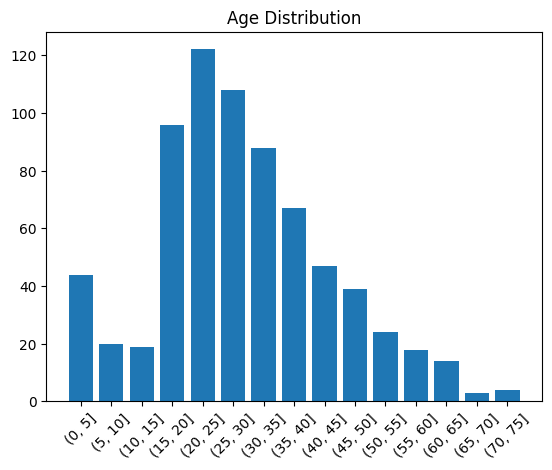

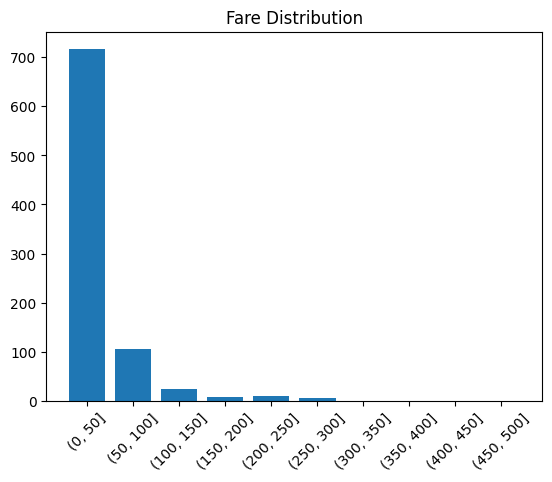

In [83]:
def distribution_count(col, col_bin):
  bins = range(0, int(max(col)), col_bin)
  df = pd.cut(col, bins=bins)
  distribution = df.value_counts()
  distribution = distribution.sort_index()
  return distribution

# Age Distribution
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(x=distribution_count(raw["Age"], 5).index.astype(str), height=distribution_count(raw["Age"], 5))
plt.title("Age Distribution")
plt.xticks(rotation=45)
plt.show()

# Fare Distribution
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.bar(x=distribution_count(raw["Fare"], 50).index.astype(str), height=distribution_count(raw["Fare"], 50))
plt.title("Fare Distribution")
plt.xticks(rotation=45)
plt.show()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


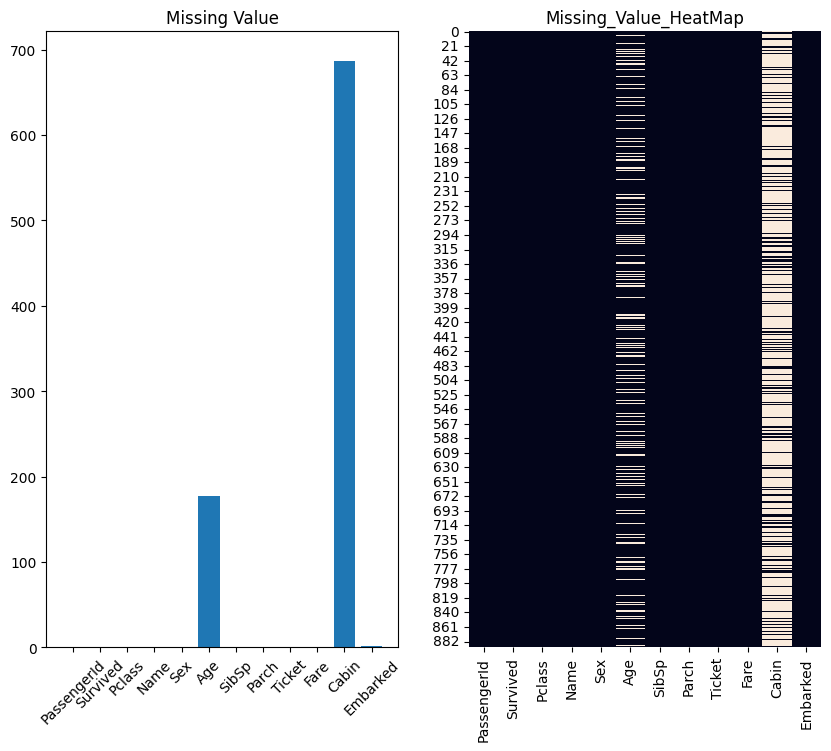

In [84]:
# 查看缺失值
# Age、Cabin、Embarked 有缺失值
isnull = raw.isnull().sum()

fig = plt.figure(figsize=(10,8))
bar_isnull = fig.add_subplot(1,2,1)

# 繪製柱狀圖，顯示每一個 feature 的 missing value 數量
bars = bar_isnull.bar(raw.columns, isnull)
plt.xticks(rotation=45)
plt.title("Missing Value")

# 繪製熱力圖，顯示 Missing Value 的位置
heatmap_isnull = fig.add_subplot(1,2,2)
sns.heatmap(raw.isnull(), cbar=False)
plt.title("Missing_Value_HeatMap")

print(isnull)


In [85]:
# 查看feature對於survived的影響
def col_survived(col_name):
  grouped = raw.groupby([col_name])["Survived"].mean()
  return grouped

print(col_survived("Sex"),"\n")
print(col_survived("Pclass"),"\n")
print(col_survived("SibSp"),"\n")
print(col_survived("Parch"),"\n")

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64 

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64 

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64 



Correlation of Feature

          Survived    Pclass       Age     SibSp     Parch      Fare  \
Survived  1.000000 -0.338481 -0.064910 -0.035322  0.081629  0.257307   
Pclass   -0.338481  1.000000 -0.339898  0.083081  0.018443 -0.549500   
Age      -0.064910 -0.339898  1.000000 -0.233296 -0.172482  0.096688   
SibSp    -0.035322  0.083081 -0.233296  1.000000  0.414838  0.159651   
Parch     0.081629  0.018443 -0.172482  0.414838  1.000000  0.216225   
Fare      0.257307 -0.549500  0.096688  0.159651  0.216225  1.000000   
Embarked  0.118026  0.028566  0.007505 -0.063794 -0.082144  0.071010   
female    0.543351 -0.131900 -0.081163  0.114631  0.245489  0.182333   
male     -0.543351  0.131900  0.081163 -0.114631 -0.245489 -0.182333   

          Embarked    female      male  
Survived  0.118026  0.543351 -0.543351  
Pclass    0.028566 -0.131900  0.131900  
Age       0.007505 -0.081163  0.081163  
SibSp    -0.063794  0.114631 -0.114631  
Parch    -0.082144  0.245489 -0.245489  
Fare     

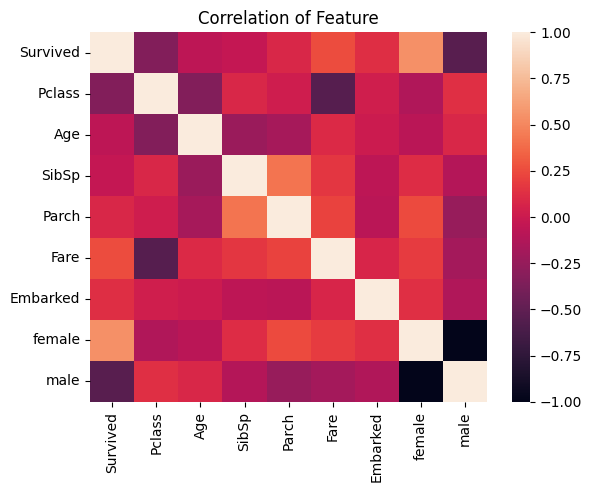

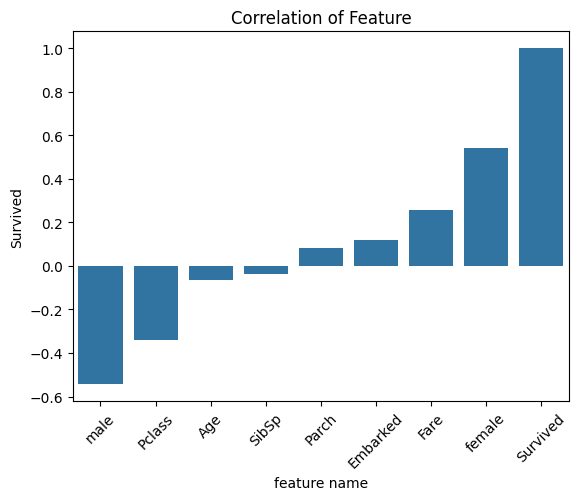

In [86]:
# 先查看包含哪些資料
# 決定保留那些資料(特徵篩選)
# Unique Value 太多的資料，也不具參考價值
# 缺失值填充
# Age、Cabin、Embarked 有缺失值
# Cabin 刪除、Embarked填補眾數、Age填補中位數
data_baseline = raw.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1)
data_baseline["Embarked"] = data_baseline["Embarked"].fillna(data_baseline["Embarked"].mode)
data_baseline["Age"] = data_baseline["Age"].fillna(data_baseline["Age"].median())
data_baseline.isnull().sum()


# categorical -> numerical
# Sex、Embarked feature
# Sex -> one hot encoding
# Embarked -> pd.factorize
sex_onehot_df = pd.get_dummies(data_baseline["Sex"])
data_baseline = data_baseline.join(sex_onehot_df).drop(["Sex"], axis=1)
data_baseline["Embarked"] = pd.factorize(data_baseline["Embarked"])[0]


# 計算相關係數
corre = data_baseline.corr()
print("Correlation of Feature\n")
print(corre)

# 繪製熱力圖
fig = plt.figure()
ax = fig.add_subplot()
sns.heatmap(corre)
plt.title("Correlation of Feature")


# 繪製相關係數柱狀圖
corre_survived = corre["Survived"].sort_values()
fig = plt.figure()
ax = fig.add_subplot()
sns.barplot(x=corre_survived.index, y=corre_survived)
plt.xticks(rotation=45)
plt.xlabel("feature name")
plt.title("Correlation of Feature")


# 特徵工程
# Age、Fare 使用裝箱法
# Age 每5為一區間
# Fare 每50為一區間
age_bins = range(0, int(max(data_baseline["Age"])), 5)
data_baseline["Age"] = pd.cut(data_baseline["Age"], bins=age_bins)

fare_bins = range(0, int(max(data_baseline["Fare"])), 50)
data_baseline["Fare"] = pd.cut(data_baseline["Fare"], bins=fare_bins)
print(data_baseline,"\n")


# 將 Age、Fare 進行Labelencoder轉換
label_encoder = LabelEncoder()
data_baseline["Age"] = label_encoder.fit_transform(data_baseline["Age"])
data_baseline["Fare"] = label_encoder.fit_transform(data_baseline["Fare"])
print(data_baseline,"\n")


# 切割資料為feature、target
X = data_baseline.drop(["Survived"], axis=1)
y = data_baseline["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 採用隨機森林分類模型
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X,y)
RF_importance = RF_model.feature_importances_
feature_col = X.columns
RF_importance_df = pd.DataFrame({"feature":feature_col, "RF_importance":RF_importance})
print(RF_importance_df,"\n")


# cross_val_score 交叉驗證
RF_score = cross_val_score(RF_model, X, y, cv=10, scoring="accuracy")
print("Accuracy：",RF_score.mean(),"\n")

In [87]:
# 測試Decsion Tree Max Depth
max_depth_range = range(1, 11)
accuracy = []
for i in max_depth_range:
  clf = DecisionTreeClassifier(max_depth=i, random_state=42)
  score = cross_val_score(clf, X, y, cv=10, scoring="accuracy").mean()
  accuracy.append(score)

best_depth = max_depth_range[accuracy.index(max(accuracy))]
best_accuracy = max(accuracy)

print(f"DecsionTreeClassifier model ：\n最佳深度：{best_depth}  最佳準確率：{best_accuracy}")

DecsionTreeClassifier model ：
最佳深度：4  最佳準確率：0.8294007490636703


In [97]:
# 使用其他模型
# 邏輯回歸(logistic regression)
# 決策樹(decision tree)
# 梯度提升樹(Gradient Boosting Tree)
# 支持向量機(SVM)
# K近鄰(KNN)
models = {
    "RF":RandomForestClassifier(n_estimators=100, random_state=42),
    "GBC":GradientBoostingClassifier(n_estimators=100, random_state=42),
    "LR":LogisticRegression(max_iter=100),
    "DTC":DecisionTreeClassifier(max_depth=4, random_state=42),
    "KNN":KNeighborsClassifier(n_neighbors=3),
    "SVC":SVC()
}

def ML_score(models, X, y, cv_num):
  total_score={}
  for model in models:
    score = cross_val_score(models[model], X, y, cv=cv_num).mean()
    total_score[model] = [score]
  return total_score
result_df = ML_score(models, X, y, 10)
result = pd.DataFrame(result_df, index=["score"])
print(result)

            RF       GBC       LR       DTC       KNN       SVC
score  0.80588  0.821573  0.79573  0.829401  0.802497  0.820437


In [89]:
# 如果Age、Fare不採用裝箱法

# data_second = raw.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1)